# HSSM MathPsych 2025: Assembling Onions

<center> <img src="./images/rv_to_hssm.png"> </center>

Welcome to the **PyMC to HSSM** tutorial:

This is an advanced tutorial, taught as part of a workshop session during the conference for Mathematical Psychology, held in Columbus Ohio, 2025.

In this short tutorial we will explore some of the features of HSSM that are geared towards users who want to do one of three things:

1. Build custom PyMC models around observation models build via HSSM low-level utilities (to e.g. break out of the hierarchical regression corsett imposed via the [Bambi](https://bambinos.github.io/bambi/) interface)
2. Work with custom models that are not provided by HSSM out of the box via the High-Level Interface (please consider contributing directly to the HSSM ecosystem eventually :)) 
3. Break our of PyMC/HSSM on the tail end to apply your own samplers!

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://githubtocolab.com/bayesflow-org/hssm-bayesflow-workshop/blob/main/notebooks/rv_to_hssm.ipynb). 

Once you are *in the colab*:

1. Follow the **installation instructions below**  (uncomment the respective code)
2.  **restart your runtime**. 

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.
Note that if you switch your runtime you have to follow the installation instructions again.

In [1]:
# If running this on Colab, please uncomment the next line
# !pip install hssm
# !pip install onnxruntime
# !pip install "zeus-mcmc>=2.5.4"

In [2]:
# # Data Files
# !wget -P  data/mathpsych_workshop_2025_data/ https://raw.githubusercontent.com/bayesflow-org/hssm-bayesflow-workshop/notebooks/data/mathpsych_workshop_2025_data/race_3_no_bias_lan_batch.onnx
# !wget -P  data/mathpsych_workshop_2025_data/ https://raw.githubusercontent.com/bayesflow-org/hssm-bayesflow-workshop/notebooks/data/mathpsych_workshop_2025_data/ddm_lan_batch.onnx


## Start of Tutorial

### Load Modules

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import hssm
import ssms
import arviz as az
import lanfactory
from pathlib import Path
import onnx
import onnxruntime as ort

wandb not available
wandb not available


### Getting ourselves a LAN / Likelihood-Network


<center> <img src="./images/simulation_to_network.png" height=250 width=650> </center>

As you will see over the course of this tutorial, ultimately we don't care about where networks might come from. Here we rely on our own pipeline to train a [LAN](https://elifesciences.org/articles/65074), however the conceptual part of this tutorial translates to likelihood functions that are derived from really any source, such as e.g. coming directly out of the [BayesFlow](https://bayesflow.org/main/index.html) package.

Our pipeline relies on two support packages:

1. [ssm-simulators](https://github.com/lnccbrown/ssm-simulators): A package with focus on fast simulation of sequential sampling models
2. [LanFactory](https://github.com/lnccbrown/LANfactory): A package to train simple neural networks geared to work seemlessly with training data generated from *ssm-simulators*


`ssm-simulators` is designed to be simple to contribute to (we continuously improve that aspect), so if you design new simulators, you should find it quite easy to add them to the package.

#### Training Data

Once you have your simulator implemented, you can specify a simple `.yaml` file, with a variation of the following contents:

```
MODEL: 'race_3_no_bias'
N_SAMPLES: 2000
N_PARAMETER_SETS: 100
DELTA_T: 0.001
N_TRAINING_SAMPLES_BY_PARAMETER_SET: 200
N_SUBRUNS: 20
GENERATOR_APPROACH: 'lan'
```

You can use the following command to generate training data:

```
generate --config-path <path/to/config.yaml> \
         --output <output/directory>
```

(Please see the basic [Readme](https://github.com/lnccbrown/ssm-simulators) for a more complete explanation)


#### Network Training

Once we have our training data, we can again use a single command to train the network. We only need to specify a few network features 
in a `network_config.yaml` file and train

```
NETWORK_TYPE: "lan" 
CPU_BATCH_SIZE: 1000
N_EPOCHS: 20
MODEL: "ddm"
LAYER_SIZES: [[100, 100, 100, 1]]
ACTIVATIONS: [['tanh', 'tanh', 'tanh']]
LABELS_LOWER_BOUND: np.log(1e-7)
```

Now we simply call:

```
torchtrain --config-path <path/to/network_config.yaml> \
           --training-data-folder <path/to/training-data> \
           --dl-workers 3 \
           --network-path-base <my_trained_network>`
```

(Same thing, this is explained in the baseid [Readme](https://github.com/lnccbrown/LANfactory) on the github page of the package)

In [4]:
# !torchtrain --config-path rv_to_hssm_data/network_config.yaml --training-data-folder torch_nb_data/training_data --dl-workers 4 --networks-path-base rv_to_hssm_data/example_network/

### Working Directly with `.onnx` networks


<center> <img src="./images/network_onnx.png" height=250 width=250> </center>

#### Utilities

The below utility turns a network which may be defined for single datapoints into a batchable version of itself (so that call can work in parallel over the trial-dimension).
We assume below that all our networks are already batchable, but keep this utility here for your convenience.

In [5]:
def make_batchable(onnx_model,
                   folder_path = "data/mathpsych_2025_data",
                   file_name = "ddm_lan_batch.onnx"):

    # Change input and output dimensions to be dynamic to allow for batching
    # (in case this is not already done)
    
    for input_tensor in onnx_model.graph.input:
        dim_proto = input_tensor.type.tensor_type.shape.dim[0]
        if not dim_proto.dim_param == "None":
            dim_proto.dim_param = "None"

    for output_tensor in onnx_model.graph.output:
        dim_proto = output_tensor.type.tensor_type.shape.dim[0]
        if not dim_proto.dim_param == "None":
            dim_proto.dim_param = "None"
    os.makedirs(folder_path, exist_ok = True)
    onnx.save(onnx_model, Path(folder_path, file_name))

#### Network Path

In [6]:
ddm_network_path = Path("data",
                        "mathpsych_workshop_2025_data",
                        "ddm_lan_batch.onnx")

#### Load and time Network

We will work natively with with neural networks that are encoded as `.onnx` files.
In this part , but here we first focus on loading an `.onnx` file into an `onnx runtime`, just to give an idea what `.onnx` is about.

Below we load a network, and time the forward pass, which should translate to the evaluation time we can expect for a single likelihood. We will illustrate this approach a bit later.

In [7]:
# Load onnx model
onnx_model = onnx.load(ddm_network_path)
input_name = onnx_model.graph.input[0].name
ort_session = ort.InferenceSession(onnx_model.SerializeToString())

# Test inference speed
import time

start = time.time()
for i in range(100):
    ort_session.run(
        None, {input_name: np.random.uniform(size=(1000, 6)).astype(np.float32)}
    )
end = time.time()
print(f"Time taken: {(end - start) / 100} seconds")

Time taken: 0.0004741120338439941 seconds


## HSSM: Low-level Interface


<center> <img src="./images/network_hssm_pymc.png" height=250 width=900> </center>

We will first work with `.onnx` files by directly refering to the filepath and letting our utilities take care of the rest. 
However, we will see one example at the end, where we manually construct a likelihood from an instantiated `.onnx` runtime. 

### Example (1): Construct your own random variable

Under the hood, a lot of the heavy lifting done by HSSM boils down to the creating of valid Random Variables that are compatible with PyMC specifications. 

In broad strokes: In probabilist programming, a minimal specification for a random variable that let's us sample all the quantities of interest for a standard Bayesian Analysis are:

- A likelihood function
- A valid simulator

If we have both of these, we can do everything. We can sample from the *posterior*, from the *prior predictive* and from the *posterior predictive*,which will cover essentially 99.9% of our needs.

Below, we use HSSM low level functionality to construct such a random variable in three simple steps. Once constructed we use it in a PyMC model natively! 

**Note**:

Truth be told, we can run MCMC without ever supplying a valid simulator and other tutorials showcase that scenario. However in such cases you are on your own once you want to sample from *posterior predictives* and/or *prior predictives*. 

#### Model

<center> <img src="./images/Race_3.png"> </center>

#### Data

We simulate a simple dataset consisting fo $750$ trials from the **Race 3** model as depicted above. HSSM has a `simulate_data()` function which comes in handy for this purpose. We can access all named models which are implemented in the [ssm-simulators](https://github.com/lnccbrown/ssm-simulators) package.

In [8]:
# Set parameters
v0 = 1.5
v1 = 0.5
v2 = 0.5
a = 1.5
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3 = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=750
)

#### Utilities

While we can use fully custom simulators in the context of this tutorial, we are sticking to simulators implemented in [ssm-simulators](https://github.com/lnccbrown/ssm-simulators) 
[ssm-simulators](https://github.com/lnccbrown/ssm-simulators) has model configuration dictionaries for every model that is implemented in the package. 

Let's take a peak below, since we have to pass various elements of this dictionary to downstream utility functions.


In [9]:
import ssms
ssms.config.model_config["race_no_bias_3"]

{'name': 'race_no_bias_3',
 'params': ['v0', 'v1', 'v2', 'a', 'z', 't'],
 'param_bounds': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t: float | numpy.ndarray = 0) -> float | numpy.ndarray>,
 'n_params': 6,
 'n_particles': 3,
 'default_params': [0.0, 0.0, 0.0, 2.0, 0.5, 0.001],
 'nchoices': 3,
 'choices': [0, 1, 2],
 'simulator': <cyfunction race_model at 0x2aed19840>}

In [10]:
from copy import deepcopy
race_3_model_config = ssms.config.model_config["race_no_bias_3"]

In [11]:
# Little utilitiy to transform the list entry for parameter bounds into a dictionary
def make_param_bound_dict(config):
    param_bounds = config["param_bounds"]
    print(param_bounds)
    param_names = config['params']
    print(param_names)
    return {param_names[i]: (param_bounds[0][i],
                             param_bounds[1][i]) for i in range(len(param_names))}

#### Setting the Network Path

In [12]:
# Networks
network_path = Path("data",
                    "mathpsych_workshop_2025_data",
                    "race_3_no_bias_lan_batch.onnx")

#### Networks to Random Variables

Remember that the `.onnx` file is just a representation for a neural network... this Network is actually a [LAN](https://elifesciences.org/articles/65074), and hence, by definition differentiable with respect to it's inputs (the parameters of the model).


<center> <img src="./images/basic_lan_pic.png" height=300 width=600> </center>

HSSM will help you construct costom PyMC random variables starting from `.onnx` files. We will see two routes to work with custom distributions in PYMC and HSSM, however more routes exist, and are in the making. Here is a list:

1. Any valid Python function (we will see this later): The `blackbox` regime
2. `.onnx` function with Network signature: `approx_differentiable`
3. JAX function with Network signature: `appox_differentiable`
4. PyTensor function / JAX function with valid likelihood signature: `analytical` 

We will ow focus on route 2., directly through PyMC, using HSSM only as a help in constructing random variabels. We will then showcase how the HSSM high-level (main) interface still allows us to work with option 2. very conveniently. 

Last, we are going to showcase option 1. via the HSSM high-level interface.

#### Constructing the Random Variable


To construct out PyMC random variables we make use of two utilities HSSM provides. 

1. `make_likelihood_callable()` allows us to pass the network path, as well as a few configuration arguments, and will construct a valid callable likelihood function (duh..) for us
2. `make_distribution()` attaches a simulator (if it is part of the `ssms-simulators` package we can pass a string here) and assembles a valid PyMC distribution for us

In [13]:
from hssm.distribution_utils.dist import (
    make_distribution,
    make_likelihood_callable,
)

# Step 1: Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=network_path,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[True for _ in range(len(race_3_model_config["params"]))],
    # params_only=False,
)

# Step 2: Define a distribution
CustomDistribution = make_distribution(
    rv="race_no_bias_3", # CustomRV,
    loglik=logp_jax_op,
    list_params=race_3_model_config["params"],
    bounds=make_param_bound_dict(race_3_model_config),
)

[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]]
['v0', 'v1', 'v2', 'a', 'z', 't']


**Note**

`make_likelihood_callable()` has a parameter `params_is_reg` to which we pass a list of `boolean` variables (all set to `True`) in our case. 

This argument sets parameters of our likelihood to scalars or vectors (trial-wise, `is_reg` for whether the parameter could be the outcome of a regression). For simplicity we set all parameters to vectors as a default. 

The conseuqence is that we will define our PyMC model below with that expectation, and multiple all our parameters by a fixed vector of ones to establish the trial-wise relation.

#### First PyMC model

<center> <img src="./images/pymc_logo.png" height=175 width=350> </center>

We could (and have) spend a whole workshop, or many, to introduce the basics of PyMC itself. It is a rich library, connects to a deep eco-system around probabilistic programming and allows us to construct generative models around our core SSM, in ways that allows us to test a plethora of hypothesis about a given dataset. 

We will, however, not get distracted too much by the intricacies of PyMC, and instead just use this occasion to showcase that *in general* all doors are now open. 

As a very basic principle, consider the construction of a PyMC model as:

1. Setting data (**Data Block**)
2. Defining priors over parameters (**Priors Block**)
3. Defining any kind of transformation on the parameters (**Deterministics Block**)
4. Defining our observation model that observes our data and ingests trial level transformed parameters (**Likelihood Block**)

In [14]:
import pymc as pm
import pytensor.tensor as pt


param_bounds_race_3 = make_param_bound_dict(race_3_model_config)

with pm.Model() as race3_pymc:
    # Data
    obs_pt = pm.Data("obs", obs_race3[["rt", "response"]].values)

    # Priors
    v0 = pm.Uniform("v0", 
                   lower=param_bounds_race_3["v0"][0],
                   upper=param_bounds_race_3["v0"][1],
                   initval=1.0)
    v1 = pm.Uniform("v1", 
                   lower=param_bounds_race_3["v1"][0],
                   upper=param_bounds_race_3["v1"][1],
                   initval=1.0)
    v2 = pm.Uniform("v2", 
                   lower=param_bounds_race_3["v2"][0],
                   upper=param_bounds_race_3["v2"][1],
                   initval=1.0)
    a = pm.Uniform("a",
                      lower=param_bounds_race_3["a"][0],
                      upper=param_bounds_race_3["a"][1],
                      initval=2.0)
    z = 0.5 # We fix this parameter because it is extremely hard to jointly identify both z and a
    t = pm.Uniform("t",
                   lower=param_bounds_race_3["t"][0],
                   upper=param_bounds_race_3["t"][1],
                   initval=0.1)

    # Vectorize parameters (Deterministics)
    v0_reg = pm.Deterministic("v0_reg", v0 * pt.ones_like(obs_race3.values[:, 0]))
    v1_reg = pm.Deterministic("v1_reg", v1 * pt.ones_like(obs_race3.values[:, 0]))
    v2_reg = pm.Deterministic("v2_reg", v2 * pt.ones_like(obs_race3.values[:, 0]))
    a_reg = pm.Deterministic("a_reg", a * pt.ones_like(obs_race3.values[:, 0]))
    t_reg = pm.Deterministic("t_reg", t * pt.ones_like(obs_race3.values[:, 0]))
    z_reg = pm.Deterministic("z_reg", z * pt.ones_like(obs_race3.values[:, 0]))

    # Likelihood
    race3_obs = CustomDistribution(
        "Race3", v0=v0_reg, v1=v1_reg, v2=v2_reg, a=a_reg, z=z_reg, t=t_reg, observed=obs_pt
    )

[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]]
['v0', 'v1', 'v2', 'a', 'z', 't']


#### String Representation of Model

In [15]:
race3_pymc

    v0 ~ Uniform(0, 2.5)
    v1 ~ Uniform(0, 2.5)
    v2 ~ Uniform(0, 2.5)
     a ~ Uniform(1, 3)
     t ~ Uniform(0, 2)
v0_reg ~ Deterministic(f(v0))
v1_reg ~ Deterministic(f(v1))
v2_reg ~ Deterministic(f(v2))
 a_reg ~ Deterministic(f(a))
 t_reg ~ Deterministic(f(t))
 z_reg ~ Deterministic(f())
 Race3 ~ SSM(v0_reg, v1_reg, v2_reg, a_reg, z_reg, t_reg)

#### Graph Representation of Model

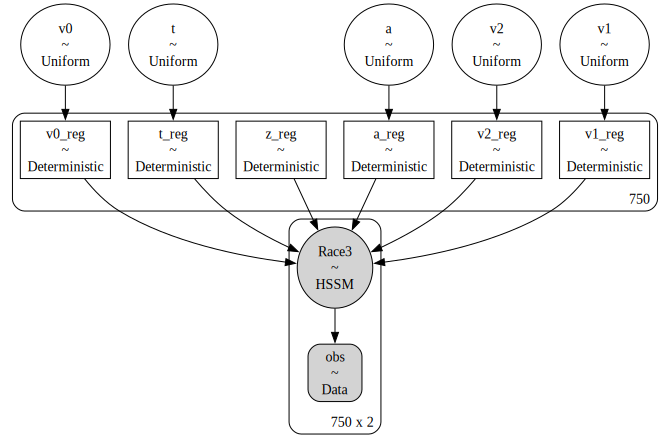

In [16]:
pm.model_to_graphviz(model=race3_pymc)

#### Sample

In [17]:
with race3_pymc:
    # Sample Posterior
    race3_pymc_trace = pm.sample(nuts_sampler = "numpyro",
                                 chains = 2,
                                 tune = 500,
                                 draws = 500)
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(race3_pymc_trace,
                                   extend_inferencedata=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Race3]


Output()

### Example (2): Slightly more complicate PyMC model

<center> <img src="./images/playground.png"> </center>

Once we are in the PyMC-universe directly, we can build models very flexibly. This includes

1. Introducing hierarchies
2. Complicated non-linear transformations on parameters
3. Time series approaches as processes over parameters (more on that by Krishn later)
4. and much much more!

Obviously this allows for things to go wrong, but you can have great fun along the way :)

Below we will build a model that is easy enough in principle, but specifically hard (impossible) to construct via the HSSM user interface directly.
But more on that a bit later!

#### Simulate Data

Notice in the data simulation below: We are applying a regresion to all of `v0`, `v1`, `v2` and `a` and de facto the `beta` parameter is shared amongst all four.


<center> <img src="./images/race_with_difficulty.png" heigh=400 width=550> </center>

In [18]:
# Simple Regression Setup
beta = 0.5
difficulty = np.random.uniform(low = -1,
                               high = 1,
                               size = 750)

# Set parameters
v0 = 1.75 - beta * difficulty
v1 = 1.75 - beta * difficulty
v2 = 1.2 - beta * difficulty
a = 2.0 + beta * difficulty
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3_reg = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=1
)

In [19]:
obs_race3_reg

,rt,response
0,0.420213,2.0
1,0.683063,0.0
2,0.618993,1.0
3,0.671982,0.0
4,0.499129,2.0
...,...,...
745,0.527966,1.0
746,0.572670,0.0
747,0.726914,2.0
748,0.817085,0.0


#### Second PyMC Model

In [20]:
import pymc as pm
from pytensor import tensor as pt

# Turn config parameter bounds into dictionary
param_bounds_race_3 = make_param_bound_dict(race_3_model_config)

with pm.Model() as race3_pymc2:
    # Data
    obs_pt = pm.Data("obs", obs_race3_reg[["rt", "response"]].values)

    # Priors
    beta = pm.Normal("beta", mu=0, sigma=0.5, initval=0.0)
    v0 = pm.Uniform("v0", 
                   lower=param_bounds_race_3["v0"][0],
                   upper=param_bounds_race_3["v0"][1],
                   initval=1.0)
    v1 = pm.Uniform("v1", 
                   lower=param_bounds_race_3["v1"][0],
                   upper=param_bounds_race_3["v1"][1],
                   initval=1.0)
    v2 = pm.Uniform("v2", 
                   lower=param_bounds_race_3["v2"][0],
                   upper=param_bounds_race_3["v2"][1],
                   initval=1.0)
    a = pm.Uniform("a",
                      lower=param_bounds_race_3["a"][0],
                      upper=param_bounds_race_3["a"][1],
                      initval=2.0)
    t = pm.Uniform("t",
                   lower=0.0,
                   upper=2.0,
                   initval=0.1)
    
    z = 0.5 # We fix this parameter because it is extremely hard to jointly identify both z and a
    

    # Compute Regressions
    reg_a = pm.Deterministic("reg_a", a + beta * difficulty)
    reg_v0 = pm.Deterministic("reg_v0", v0 - beta * difficulty)
    reg_v1 = pm.Deterministic("reg_v1", v1 - beta * difficulty)
    reg_v2 = pm.Deterministic("reg_v2", v2 - beta * difficulty)

    # Vectorize remaining parameters
    reg_t = pm.Deterministic("reg_t", t * pt.ones_like(obs_race3_reg.values[:, 0]))
    reg_z = pm.Deterministic("reg_z", z * pt.ones_like(obs_race3_reg.values[:, 0]))

    # Likelihood
    race3_obs = CustomDistribution(
        "Race3", v0=reg_v0, v1=reg_v1, v2=reg_v2, a=reg_a, z=reg_z, t=reg_t, observed=obs_pt
    )

[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]]
['v0', 'v1', 'v2', 'a', 'z', 't']


#### Graph Representation of Model

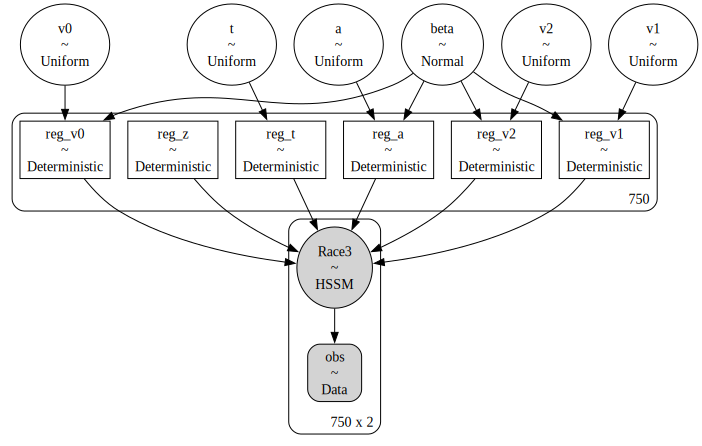

In [21]:
pm.model_to_graphviz(model=race3_pymc2)

#### Sample

In [22]:
with race3_pymc2:
    # Sample Posterior
    race3_pymc_trace2 = pm.sample(nuts_sampler = "numpyro",
                                  chains = 2,
                                  tune = 500,
                                  draws = 500)
    
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(race3_pymc_trace2,
                                   extend_inferencedata=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 326 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Race3]


Output()

In [23]:
az.summary(race3_pymc_trace2, var_names = ["~reg"], filter_vars = "like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.471,0.032,0.417,0.535,0.002,0.001,374.0,414.0,1.01
v0,1.852,0.114,1.648,2.036,0.008,0.006,182.0,262.0,1.02
v1,1.759,0.136,1.520,2.005,0.011,0.005,161.0,207.0,1.02
v2,1.331,0.142,1.061,1.589,0.012,0.006,132.0,159.0,1.03
a,2.008,0.112,1.810,2.211,0.011,0.005,109.0,161.0,1.04
t,0.291,0.010,0.272,0.308,0.001,0.000,141.0,173.0,1.03


## HSSM: Medium-level Interface

#### Load Module

HSSM Provides a (growing) set of pre-assembled random variables out of the box, which we can load directly from the `likelihoods` submodule.
For these pre-assmebled random variables, the workflow is even simpler!

In [24]:
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import DDM

#### Simulate Data

In [25]:
# Simulate
param_dict_pymc = dict(v=0.5,
                       a=1.5,
                       z=0.5,
                       t=0.5,
                       theta=0.0)
dataset_pymc = hssm.simulate_data(model="ddm", theta=param_dict_pymc, size=1000)

In [26]:
dataset_pymc

,rt,response
0,0.905230,-1.0
1,2.922027,1.0
2,1.372667,-1.0
3,2.080705,1.0
4,3.930056,1.0
...,...,...
995,2.345660,-1.0
996,1.017464,1.0
997,3.175778,-1.0
998,3.000363,-1.0


#### PyMC Model

In [27]:
import pymc as pm

with pm.Model() as ddm_pymc:
    # Data
    obs_pt = pm.Data("obs", dataset_pymc[["rt", "response"]].values)

    # Priors
    v = pm.Uniform("v", 
                   lower=-10.0,
                   upper=10.0)
    a = pm.HalfNormal("a",
                      sigma=2.0)
    z = pm.Uniform("z",
                   lower=0.01,
                   upper=0.99)
    t = pm.Uniform("t",
                   lower=0.0,
                   upper=0.6)
    
    # Likelihood
    ddm = DDM(
        "DDM", v=v, a=a, z=z, t=t, observed=obs_pt
    )

#### Graph Representation of Model

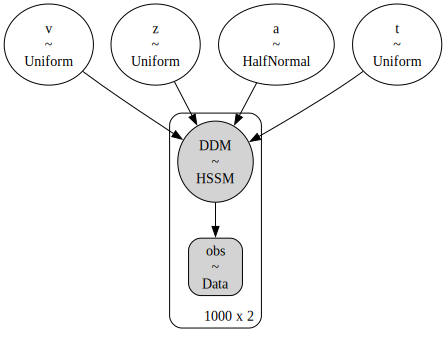

In [28]:
pm.model_to_graphviz(model=ddm_pymc)

#### Sample

In [29]:
with ddm_pymc:
    # Sample Posterior
    ddm_pymc_trace = pm.sample(chains = 2,
                               draws = 500,
                               tune = 500)
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(ddm_pymc_trace,
                                   extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t]
/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [DDM]


Output()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:218: UserWarning: A valid var_name should be provided, found {'theta'} expected from {'v', 'z', 'a', 't'}
  warnings.warn(


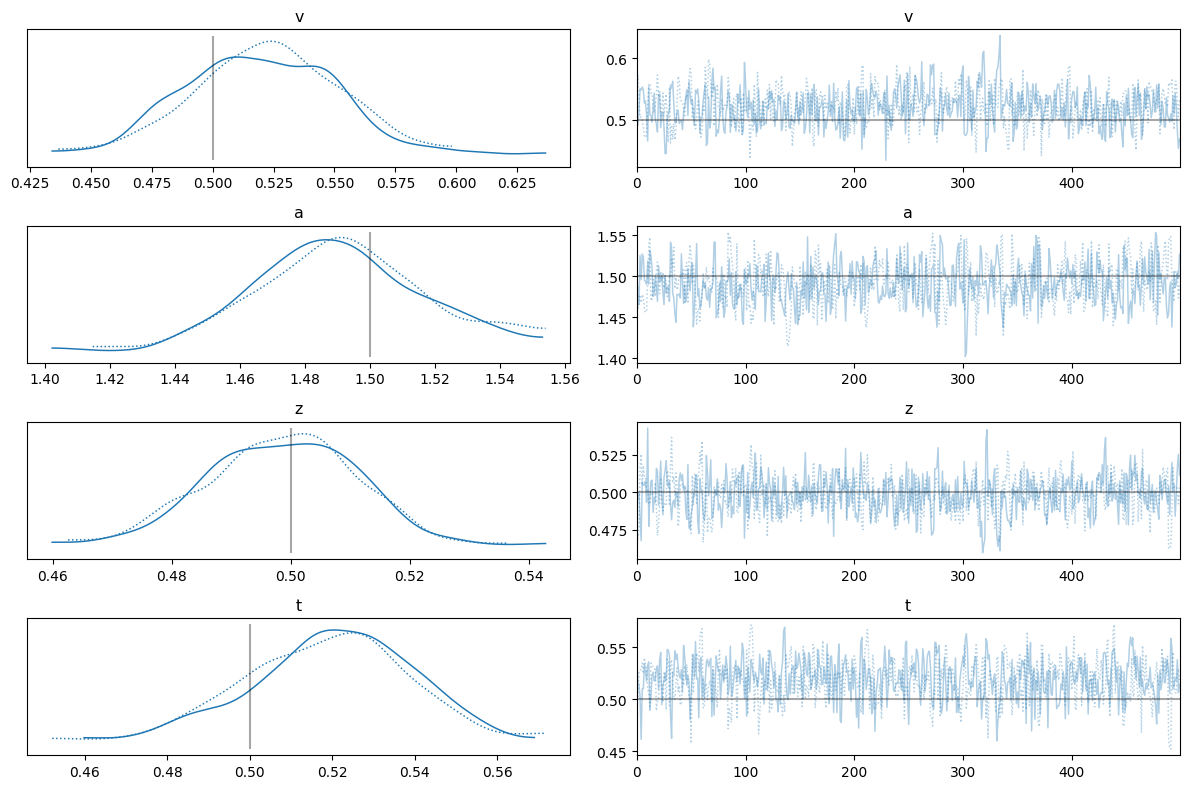

In [30]:
az.plot_trace(
    ddm_pymc_trace,
    lines=[(key_, {}, param_dict_pymc[key_]) \
           for key_ in param_dict_pymc],
)

plt.tight_layout()

## HSSM: High-Level Interface

### (Re) Defining the Network Path

In [31]:
# Networks
network_path = Path("data",
                    "mathpsych_workshop_2025_data",
                    "race_3_no_bias_lan_batch.onnx")

### Data and Underlying Model


This example focuses on a `Race` model with three choice options. See the picture below for an illustration:

<center> <img src="./images/Race_3.png"> </center>

#### Simulate Data

In [32]:
# Set parameters
v0 = 1.0
v1 = 0.5
v2 = 0.25
a = 1.5
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3 = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=1000
)

### HSSM class

In [33]:
param_bounds_race_3 = make_param_bound_dict(race_3_model_config)
parameters_race_3 = race_3_model_config["params"]

hssm_race3 = hssm.HSSM(
    data=obs_race3,
    model="race_no_bias_3",  # some name for the model
    model_config={
        "list_params": parameters_race_3,
        "bounds": param_bounds_race_3,
        "backend": "jax", # can choose "jax" or "pytensor" here
    },  # minimal specification of model parameters and parameter bounds
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=network_path,
    choices=[0, 1, 2],  # list the legal choice options
    z=0.5,
    # p_outlier=0,
)

[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]]
['v0', 'v1', 'v2', 'a', 'z', 't']
Model initialized successfully.


#### Graph Representation of the Model

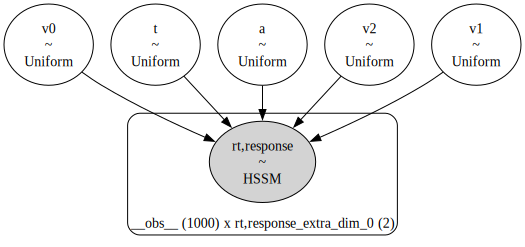

In [34]:
hssm_race3.graph()

#### Sample

In [35]:
hssm_race3_idata = hssm_race3.sample(draws=500,
                                     tune=200,
                                     chains = 2,
                                     discard_tuned_samples=False)

Using default initvals. 



  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:01<00:00, 758.97it/s]


In [36]:
az.summary(hssm_race3_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0,1.026,0.111,0.822,1.235,0.007,0.004,257.0,254.0,1.00
t,0.305,0.006,0.294,0.317,0.000,0.000,283.0,340.0,1.00
v2,0.275,0.111,0.062,0.466,0.007,0.004,269.0,261.0,1.01
a,1.350,0.065,1.228,1.472,0.004,0.003,228.0,313.0,1.00
v1,0.502,0.108,0.309,0.706,0.006,0.004,306.0,498.0,1.00


/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


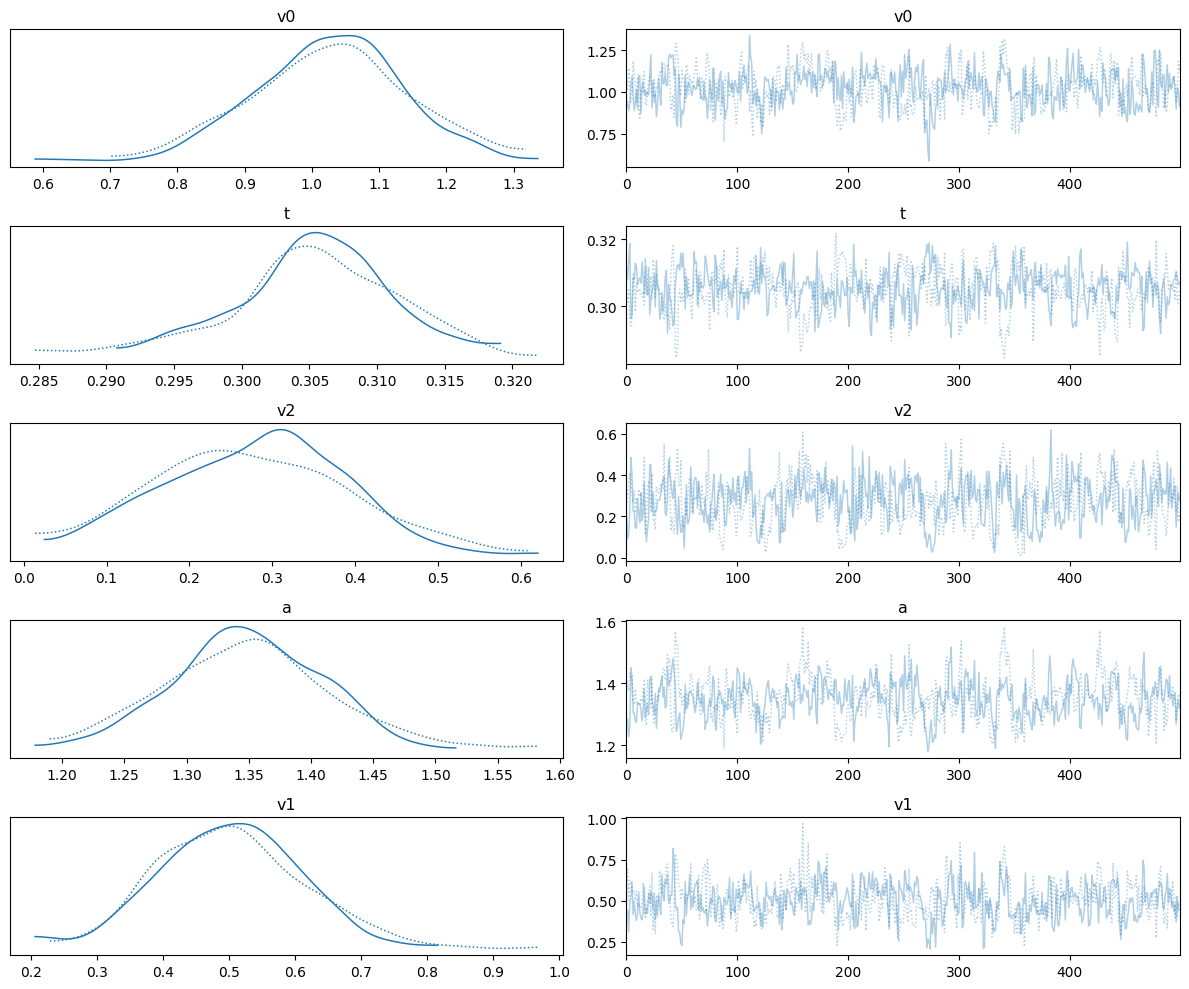

In [37]:
az.plot_trace(hssm_race3.traces,
             var_names=["~v0_mean"],
             filter_vars = 'like')
plt.tight_layout()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


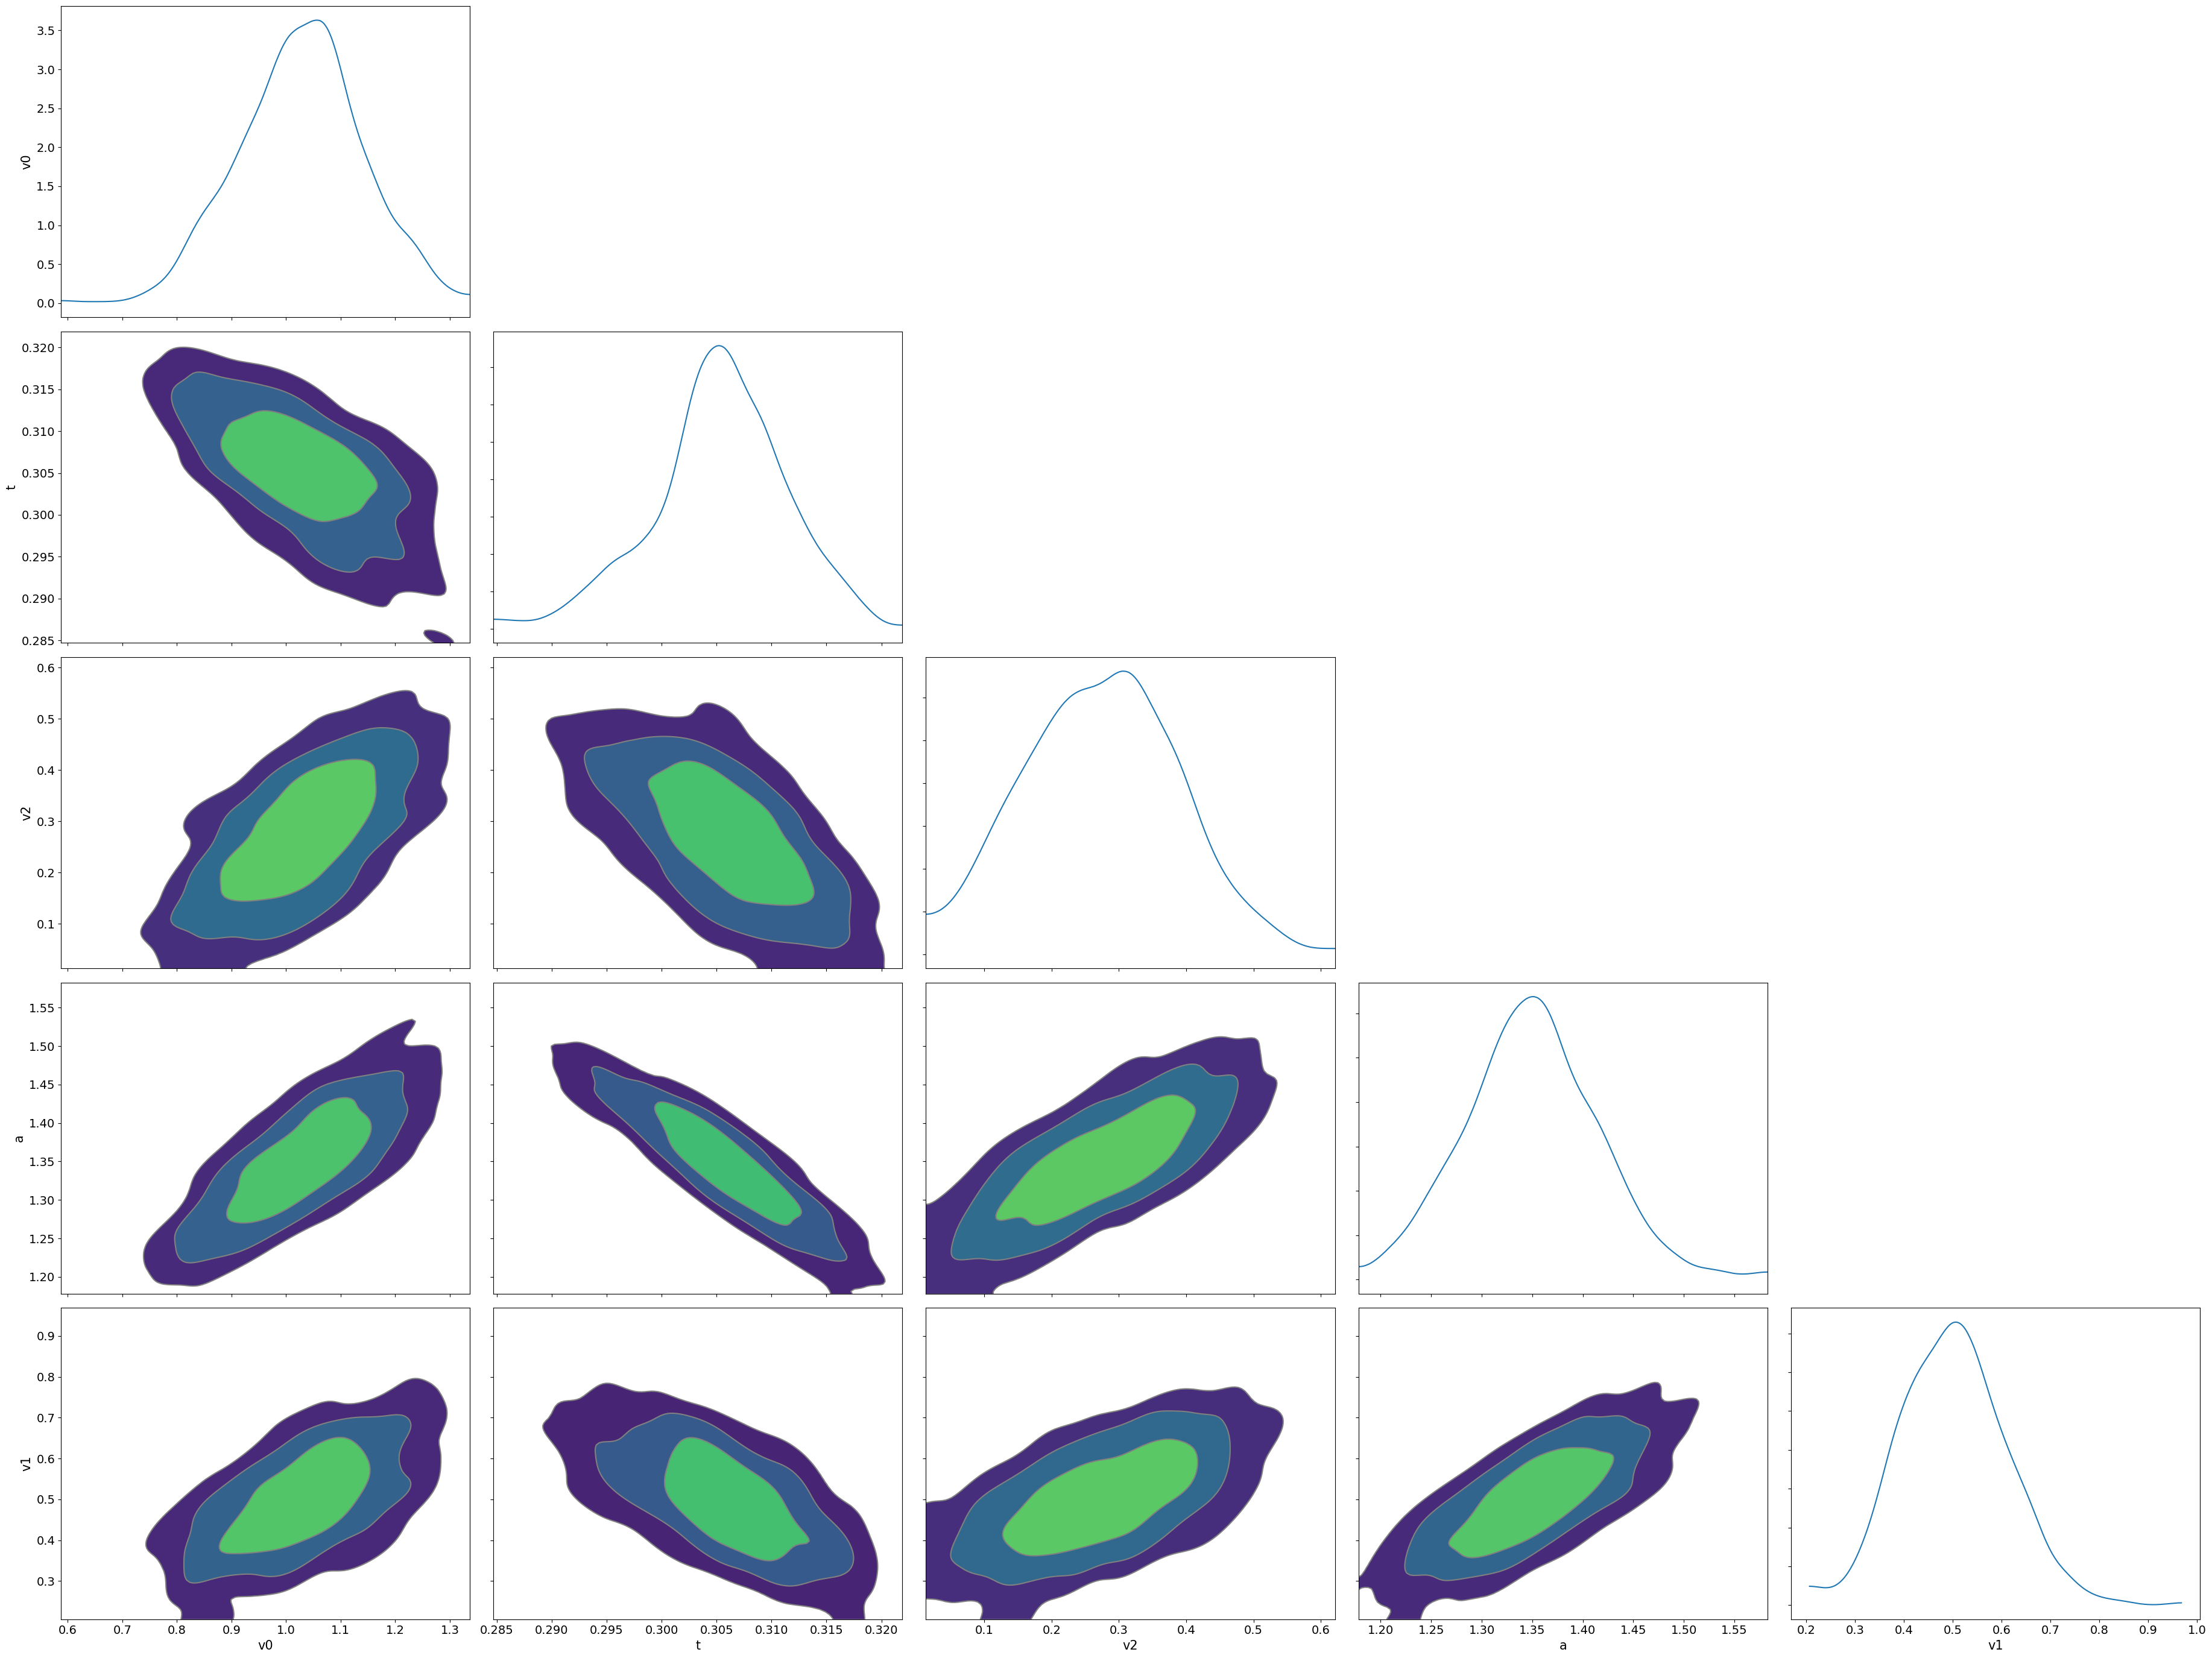

In [38]:
az.plot_pair(hssm_race3.traces,
             var_names=["~v0_mean"],
             filter_vars= 'like',
             kind = "kde",
             marginals = True)
plt.tight_layout()

## Don't like any of the samplers in PyMC?
### Help yourself!

If you don't like the samplers HSSM or even PyMC can provide out of the box, we have a remedy.
You can just compile the likelihood, and use it as a simple function downstream, however you like!

### Compiling the likelihood

In [39]:
logp_fun = hssm_race3.compile_logp()
print(logp_fun(hssm_race3.initial_point(transformed=False)))

-5626.5409803224


### Timing the compiled likelihood

In [40]:
# time
import time

my_start_point = hssm_race3.initial_point(transformed=False)
start_time = time.time()
for i in range(1000):
    logp_fun(my_start_point)
print((time.time() - start_time) / 1000)

0.0013158419132232666


### Define a simple wrapper and sample via third party library

<center> <img src="./images/zeus_sampler.png" height=300 width=600> </center>

In [41]:
def mylogp(theta: list[float]) -> float:
    """Wrap function for compiled log probability function to work with zeus sampler.

    Args
    ----
        theta: List of model parameters [v, a, z, t] where:
            v: Drift rate
            a: Boundary separation
            z: Starting point
            t: Non-decision time

    Returns
    -------
        float: Log probability value for the given parameters
    """
    v0, v1, v2, a, t = theta
    return logp_fun({"v0": v0, "v1": v1, "v2": v2, "a": a, "t": t})

In [42]:
import zeus

start = np.random.uniform(low=-0.2,
                          high=0.2,
                          size=(10, 5)) + np.tile([0.5, 1.5, 0.5, 1.5, 0.3], (10, 1)
)
sampler = zeus.EnsembleSampler(10, 5, mylogp)

In [43]:
sampler.run_mcmc(start, 1000)

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


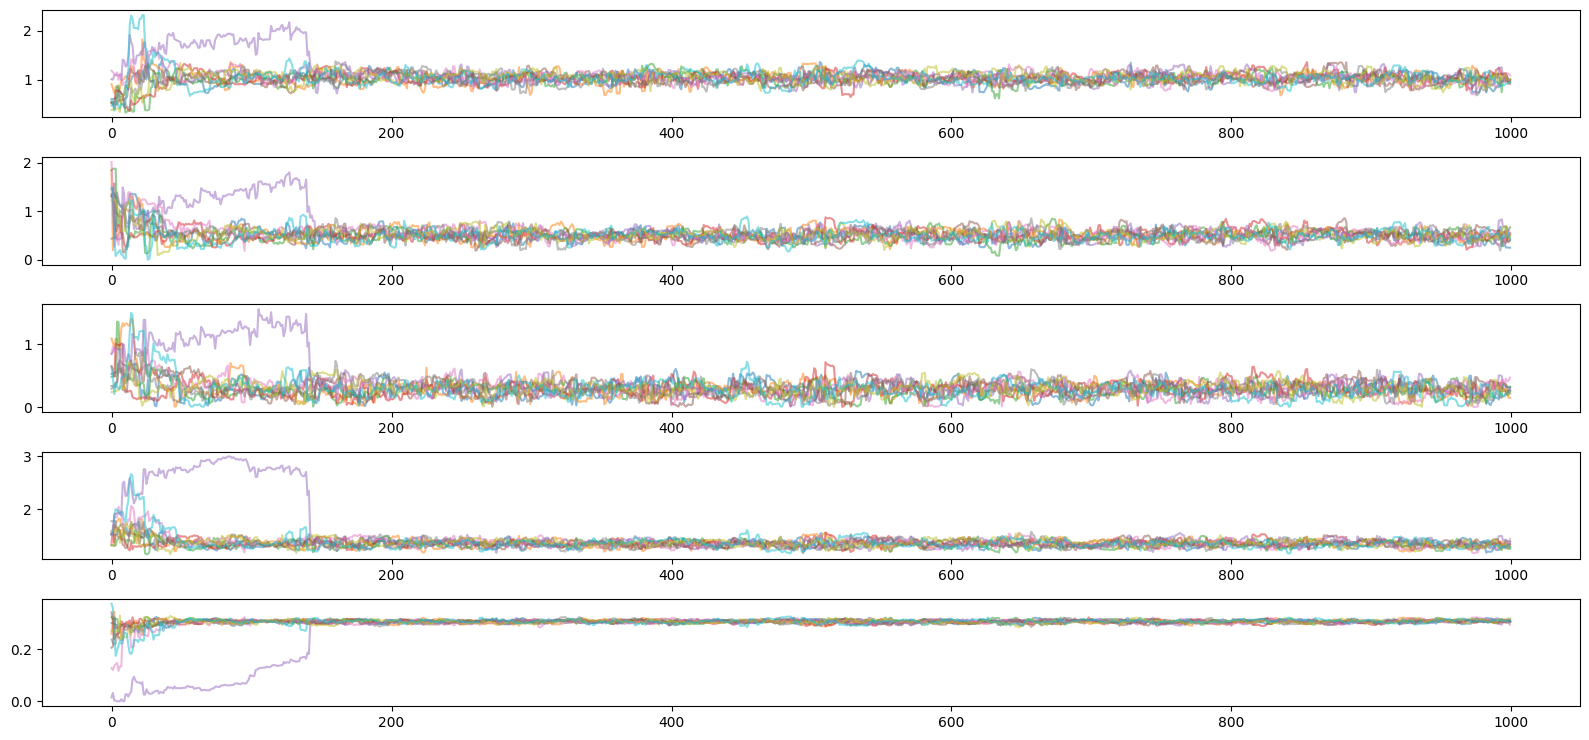

In [44]:
plt.figure(figsize=(16, 1.5 * 5))
for n in range(5):
    plt.subplot2grid((5, 1), (n, 0))
    plt.plot(sampler.get_chain()[:, :, n], alpha=0.5)
plt.tight_layout()
plt.show()

## The End:

We have seen how to use introduce custom models into HSSM workflows, how to do posterior sampling with HSSM models via third party libraries and how to use the low-level functionality of HSSM to construct random variables that can be used via PyMC!

This tutorial ends here, but please feel invited to take occasion and check out more advanced topics from the HSSM docs!

## Pointers to more advanced Topics

We are scratching only the surface of what cann be done with [HSSM](https://github.com/lnccbrown/HSSM/), let alone the broader eco-system supporting [simulation based inference (SBI)](https://simulation-based-inference.org/).

Check out our simulator package, [ssm-simulators](https://github.com/lnccbrown/ssm-simulators) as well as our our little neural network library for training [LANs](https://elifesciences.org/articles/65074), [lanfactory](https://github.com/lnccbrown/LANfactory). 

Exciting work is being done (more on this in the next tutorial) on connecting to other packages in the wider eco-system, such as [BayesFlow](https://bayesflow.org/main/index.html) as well as the [sbi](https://sbi-dev.github.io/sbi/v0.24.0/) package.

Here is a taste of advanced topics with links to corresponding tutorials:

- [Variational Inference with HSSM](https://lnccbrown.github.io/HSSM/tutorials/variational_inference/)
- [Build PyMC models with HSSM random variables](https://lnccbrown.github.io/HSSM/tutorials/pymc/)
- [Connect compiled models to third party MCMC libraries](https://lnccbrown.github.io/HSSM/tutorials/compile_logp/)
- [Construct custom models from simulators and contributed likelihoods](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/)
- [Using link functions to transform parameters](https://lnccbrown.github.io/HSSM/api/link/#hssm.Link)

you will find this and a lot more information in the [official documentation](https://lnccbrown.github.io/HSSM/)